# Classification fine-tuning using Helical

## Cell type classification task

In [1]:
from helical.utils import get_anndata_from_hf_dataset
from helical import Geneformer, GeneformerConfig, GeneformerFineTuningModel, scGPT, scGPTConfig, scGPTFineTuningModel, UCE, UCEConfig, UCEFineTuningModel
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import logging, warnings

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

2024-09-27 14:47:22.858967: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 14:47:22.867799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 14:47:22.877475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 14:47:22.880370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 14:47:22.888832: I tensorflow/core/platform/cpu_feature_guar

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Install datasets

In [ ]:
from datasets import load_dataset
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, download_mode="reuse_cache_if_exists")

In [4]:
train_dataset = get_anndata_from_hf_dataset(ds["train"])
test_dataset = get_anndata_from_hf_dataset(ds["test"])

## Prepare training labels

- For this classification task we want to predict cell type classes
- So we save the cell types as a list

In [5]:
cell_types_train = list(np.array(train_dataset.obs["LVL1"].tolist()))
cell_types_test = list(np.array(test_dataset.obs["LVL1"].tolist()))

- We convert these string labels into unique integer classes for training

In [6]:
label_set = set(cell_types_train)
class_id_dict = dict(zip(label_set, [i for i in range(len(label_set))]))
id_class_dict = {v: k for k, v in class_id_dict.items()}

for i in range(len(cell_types_train)):
    cell_types_train[i] = class_id_dict[cell_types_train[i]]

for i in range(len(cell_types_test)):
    cell_types_test[i] = class_id_dict[cell_types_test[i]]



## Geneformer Fine-Tuning

Load the desired pretrained Geneformer model and desired configs

In [ ]:
geneformer_config = GeneformerConfig(device=device, batch_size=5, model_name="gf-6L-30M-i2048")
geneformer = Geneformer(configurer = geneformer_config)

Process the data so it is in the correct form for Geneformer

In [ ]:
geneformer_train_dataset = geneformer.process_data(train_dataset)
geneformer_test_dataset = geneformer.process_data(test_dataset)

Geneformer makes use of the Hugging Face dataset class and so we need to add the labels as a column to this dataset

In [20]:
geneformer_train_dataset = geneformer_train_dataset.add_column("LVL1", cell_types_train)
geneformer_test_dataset = geneformer_test_dataset.add_column("LVL1", cell_types_test)

Define the Geneformer Fine-Tuning Model from the Helical package which appends a fine-tuning head automatically from the list of available heads
- Define the task type, which in this case is classification
- Defined the output size, which is the number of unique labels for classification

In [22]:
geneformer_fine_tune = GeneformerFineTuningModel(geneformer_model=geneformer, fine_tuning_head="classification", output_size=len(label_set))

Fine-tune the model

In [23]:
geneformer_fine_tune.train(train_dataset=geneformer_train_dataset, validation_dataset=geneformer_test_dataset, label="LVL1")

INFO:helical.models.geneformer.fine_tuning_model:Freezing the first 2 encoder layers of the Geneformer model during fine-tuning.
INFO:helical.models.geneformer.fine_tuning_model:Starting Fine-Tuning
Fine-Tuning Validation: 100%|██████████| 1268/1268 [00:44<00:00, 28.29it/s, accuracy=0.991]
INFO:helical.models.geneformer.fine_tuning_model:Fine-Tuning Complete. Epochs: 1


In [24]:
outputs = geneformer_fine_tune.get_outputs(geneformer_test_dataset)

Generating Outputs: 100%|██████████| 1268/1268 [00:45<00:00, 27.78it/s]


In [25]:
print(classification_report(cell_types_test,outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       938
           1       0.99      1.00      0.99      3001
           2       1.00      1.00      1.00      2321
           3       0.59      0.84      0.70        19
           4       0.95      0.97      0.96        38
           5       0.67      0.21      0.32        19

    accuracy                           0.99      6336
   macro avg       0.86      0.83      0.82      6336
weighted avg       0.99      0.99      0.99      6336



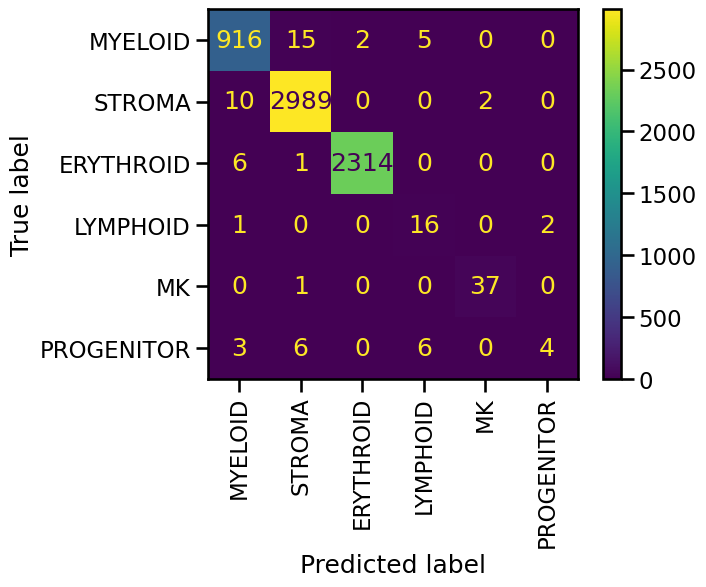

In [26]:
cm = confusion_matrix(cell_types_test, outputs.argmax(axis=1))

# Get unique labels in the order they appear in the confusion matrix
unique_labels = np.unique(np.concatenate((cell_types_test, outputs.argmax(axis=1))))

# Use id_class_dict to get the class names
class_names = [id_class_dict[label] for label in unique_labels]

# Create and plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical', values_format='d')
disp.figure_.set_facecolor("none")

## scGPT Fine-Tuning

Now the same procedure with scGPT
- Loading the model and setting desired configs

In [15]:
scgpt_config=scGPTConfig(batch_size=10, device=device)
scgpt = scGPT(configurer=scgpt_config)

A slightly different methodology for getting the dataset for scGPT since it does not make use of the Hugging Face Dataset class
- Split the data into a train and validation set

In [16]:
dataset = scgpt.process_data(train_dataset, gene_names = "gene_name")
validation_dataset = scgpt.process_data(test_dataset, gene_names = "gene_name")

Define the scGPT fine-tuning model with the desired head and number of classes

In [17]:
scgpt_fine_tune = scGPTFineTuningModel(scGPT_model=scgpt, fine_tuning_head="classification", output_size=len(label_set))

For scGPT fine tuning we have to pass in the labels as a separate list
- This is the same for the validation and training sets

In [18]:
scgpt_fine_tune.train(train_input_data=dataset, train_labels=cell_types_train, validation_input_data=validation_dataset, validation_labels=cell_types_test)

Fine-Tuning Validation: 100%|██████████| 634/634 [00:38<00:00, 16.50it/s, accuracy=0.983]


In [19]:
outputs = scgpt_fine_tune.get_outputs(validation_dataset)

Fine-Tuning Validation: 100%|██████████| 634/634 [00:35<00:00, 18.01it/s]


In [20]:
print(classification_report(cell_types_test,outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2321
           1       0.75      0.95      0.84        38
           2       0.96      0.97      0.97       938
           3       0.32      0.84      0.46        19
           4       1.00      0.99      0.99      3001
           5       0.00      0.00      0.00        19

    accuracy                           0.98      6336
   macro avg       0.67      0.79      0.71      6336
weighted avg       0.99      0.98      0.98      6336



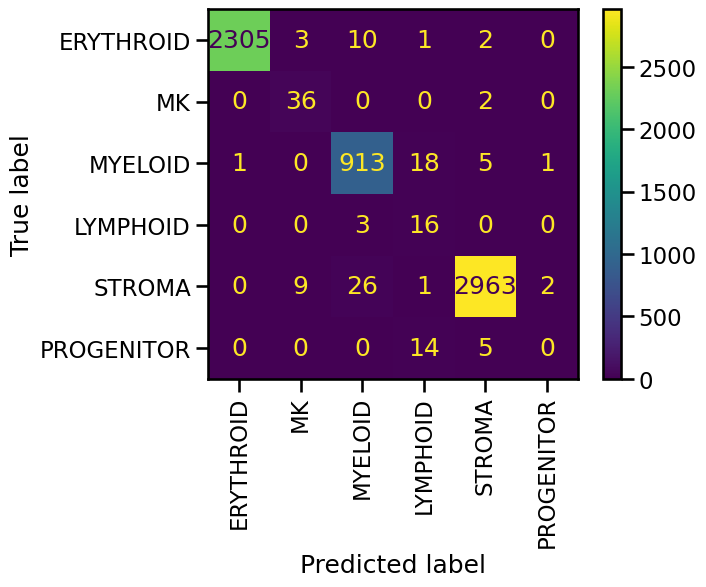

In [21]:
cm = confusion_matrix(cell_types_test, outputs.argmax(axis=1))

# Get unique labels in the order they appear in the confusion matrix
unique_labels = np.unique(np.concatenate((cell_types_test, outputs.argmax(axis=1))))

# Use id_class_dict to get the class names
class_names = [id_class_dict[label] for label in unique_labels]

# Create and plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical', values_format='d')
disp.figure_.set_facecolor("none")


## UCE Fine-Tuning

In [7]:
uce_config=UCEConfig(batch_size=5, device=device)
uce = UCE(configurer=uce_config)

Prepare data the same way as for scGPT
- Add names for each dataset, as datasets are stored as .npz files and separate files are needed

In [8]:
dataset = uce.process_data(train_dataset, name="train", gene_names="gene_name")
validation_dataset = uce.process_data(test_dataset, name="validation", gene_names="gene_name")

Define the fine-tuning model

In [9]:
uce_fine_tune = UCEFineTuningModel(uce_model=uce, fine_tuning_head="classification", output_size=len(label_set))

Fine-tune the model

In [10]:
uce_fine_tune.train(train_input_data=dataset, train_labels=cell_types_train, validation_input_data=validation_dataset, validation_labels=cell_types_test)

Fine-Tuning Validation: 100%|██████████| 634/634 [01:28<00:00,  7.16it/s, accuracy=0.474]


In [11]:
outputs = uce_fine_tune.get_outputs(validation_dataset)

Fine-Tuning Validation: 100%|██████████| 634/634 [01:23<00:00,  7.61it/s]


In [13]:
print(classification_report(cell_types_test,outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2321
           1       0.00      0.00      0.00        38
           2       0.00      0.00      0.00       938
           3       0.00      0.00      0.00        19
           4       0.47      1.00      0.64      3001
           5       0.00      0.00      0.00        19

    accuracy                           0.47      6336
   macro avg       0.08      0.17      0.11      6336
weighted avg       0.22      0.47      0.30      6336



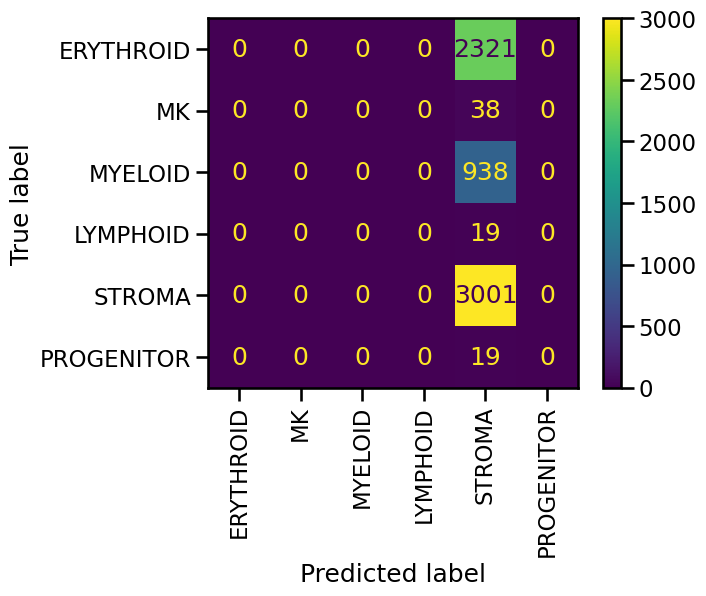

In [14]:
cm = confusion_matrix(cell_types_test, outputs.argmax(axis=1))

# Get unique labels in the order they appear in the confusion matrix
unique_labels = np.unique(np.concatenate((cell_types_test, outputs.argmax(axis=1))))

# Use id_class_dict to get the class names
class_names = [id_class_dict[label] for label in unique_labels]

# Create and plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical', values_format='d')
disp.figure_.set_facecolor("none")